# Surface Algebras as Hybrid Qudit Surface Codes in Google Cirq

In [1]:
pip install cirq

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show cirq

Name: cirq
Version: 1.1.0
Summary: A framework for creating, editing, and invoking Noisy Intermediate Scale Quantum (NISQ) circuits.
Home-page: http://github.com/quantumlib/cirq
Author: The Cirq Developers
Author-email: cirq-dev@googlegroups.com
License: Apache 2
Location: /Users/amelieschreiber/opt/anaconda3/lib/python3.9/site-packages
Requires: cirq-aqt, cirq-core, cirq-google, cirq-ionq, cirq-pasqal, cirq-rigetti, cirq-web
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cirq

In [4]:
# Original Version: 0.8.1

Device layouts such as the following are becoming standard in quantum computing due to the impact of Kitaev's torus codes for topological error correction and quantum memory. 

In [5]:
# print(cirq.google.Bristlecone)

While the above diagram of Google's Bristlecone quantum processor may be interesting to look at, there are more mathematically interesting architectures that we can study. In particular, any graph embedded in a two-dimensional surface can be used to construct a **surface code**. In this notebook we will construct such codes with **hybrid qudits**. Qudits generalize the notion of qubits to arbitrary dimensions, and hybrid codes allow for mixing qudits of different dimensions in the code. These codes are interesting for several reasons. First, some of them provide very efficient error correcting codes. Second, they can be used to boostrap a quantum field theory and they are closely related to various mathematical concepts such as Langlands and L-functions. We won't go into the details of this here as this is simply code for constructing the surface codes themselves and implementing them on Google's hardware using Cirq. 

In [6]:
from collections import Counter
from typing import Tuple, List

from networkx import MultiGraph
import networkx as nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation

import matplotlib.pyplot as plt


# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary = self.code_graph.neighbors(face)
        return boundary

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def draw(self, node_type='', layout = ''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        
        if layout == 'spring':
            pos=nx.spring_layout(self.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show() # display
        

In [7]:
import cirq
import numpy as np
from typing import Tuple
import networkx as nx

# from qiskit import
# from src import SurfaceCodeGraph


class CirqSurfaceCodeCircuit():

    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        # super().__init__()
        self.sigma = sigma
        self.alpha = alpha

        self.scgraph = SurfaceCodeGraph(self.sigma, self.alpha)

        '''
        Compute the permutation corresponding to phi and create a 
        'surface code circuit' based on a (multi)graph 'surface_code_graph'
        given by sigma, alpha, and phi
        Create quantum and classical registers based on the number of nodes in G
        '''
        # f = self.scgraph.compute_phi()
        self.phi = self.scgraph.phi

        self.qubits = [cirq.NamedQubit(str(node)) for node in self.scgraph.code_graph.nodes]
        self.circuit = cirq.Circuit()

        self.node_info = self.scgraph.node_dict
        self.sigma_dict, self.alpha_dict, self.phi_dict = self.node_info

        for cycle in self.sigma:
            self.circuit.append(cirq.H(cirq.NamedQubit(str(cycle))))

        for cycle in self.phi:
            self.circuit.append(cirq.H(cirq.NamedQubit(str(cycle))))

    def draw_circuit(self, render=''):
        # if render == 'mpl':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw('mpl')

        # if render == 'plain':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw()

        if render == '':
            print(self.circuit)

    def x_measurement(self, qubit):
        """Measure 'qubit' in the X-basis
        :param qubit: a name to designate a cirq.NamedQubit(str(qubit))
        :return None
        """
        self.circuit.append(cirq.H(cirq.NamedQubit(str(qubit))))
        self.circuit.append(cirq.measure(cirq.NamedQubit(str(qubit))))
        self.circuit.append(cirq.H(cirq.NamedQubit(str(qubit))))

    def star_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CX gates to surrounding qubits of a star then measures star qubit in X-basis
        :param vertex:
        :return:  self.circ, self.scgraph, self.node_info
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circuit.append(cirq.CNOT(cirq.NamedQubit(str(vertex)), cirq.NamedQubit(str(node))))
        self.x_measurement(vertex)

    def face_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CZ gates to surrounding qubits on the boundary of a face then measures face qubit in X-basis
        :param vertex:
        :return:
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circuit.append(cirq.CZ(cirq.NamedQubit(str(vertex)), cirq.NamedQubit(str(node))))

        self.x_measurement(vertex)

    def X_1_chain(self, edges):
        """
        Pauli product X operator for arbitrary 1-cochain given by
        a list of edges
        """
        for edge in edges:
            self.circuit.append(cirq.X(cirq.NamedQubit(str(edge))))

    def Z_1_chain(self, edges):
        """
        Pauli product Z operator for arbitrary 1-chain given by
        a list of edges
        """
        for edge in edges:
            self.circuit.append(cirq.Z(cirq.NamedQubit(str(edge))))

    def product_Z(self, faces):
        """
        Pauli product Z operator for arbitrary 2-chain boundary
        """

        boundary_nodes = self.scgraph.del_2(faces)
        for node in boundary_nodes:
            self.circuit.append(cirq.Z(cirq.NamedQubit(str(node))))

    def product_X(self, stars):
        """
        Pauli product X operator for arbitrary 0-cochain coboundary
        """
        coboundary_nodes = self.scgraph.delta_1(stars)
        for node in coboundary_nodes:
            self.circuit.append(cirq.X(cirq.NamedQubit(str(node))))



    def draw_graph(self, node_type='', layout=''):
        if layout == 'spring':
            pos = nx.spring_layout(self.scgraph.code_graph)
        if layout == 'spectral':
            pos = nx.spectral_layout(self.scgraph.code_graph)
        if layout == 'planar':
            pos = nx.planar_layout(self.scgraph.code_graph)
        if layout == 'shell':
            pos = nx.shell_layout(self.scgraph.code_graph)
        if layout == 'circular':
            pos = nx.circular_layout(self.scgraph.code_graph)
        if layout == 'spiral':
            pos = nx.spiral_layout(self.scgraph.code_graph)
        if layout == 'random':
            pos = nx.random_layout(self.scgraph.code_graph)
        if node_type == 'cycles':
            self.scgraph.draw('cycles', layout)
        if node_type == 'dict':
            self.scgraph.draw('dict', layout)

## Dessins and Constellations

Constructing a surface code given by an arbitrary graph embedded in a surface (i.e. a compact 2-manifold) is easy. All we need are two permutations $\sigma$ and $\alpha$. These are closely related to "dessins d'enfants", cellularly embedded graphs, "ribbon graphs", tesselations of the hyperbolic plane/Poincaré disk, Fuchsian and triangle groups, and many other very interesting mathematical objects.

"**Dessins d’enfants**" are, in the simplest terms, *bipartite* graphs embedded in a compact Riemann surface (without boundary). They are combinatorial tools used in the study of Inverse Galois Theory, orbits of the absolute Galois group of a number field, and ”Belyi functions”, which are coverings of the sphere $\mathbb{P}^1(\mathbb{C})$ ramified at most at three points, which can be assumed to be $\{0, 1, \infty \}$ (up to a Mobius transformation). One way of constructing dessins is via a combinatorial object called a ”**3-constellation**” $C = [\sigma, \alpha, \phi]$, which is a triple of permutations such that, 

1. The group $G = \langle \sigma, \alpha, \phi \rangle$, generated by the three permutations, acts transitively on $[n] = \{0, 1,2,...,n-1\}$, the set of $n$-points. 
2. The product $\sigma \alpha \phi = \mathbf{id}$, is the identity. So $\phi = (\sigma \alpha)^{-1}$.

If we restrict to the case where $\alpha$ is a fixed-point free involution, we obtain part of the standard definition of a **Brauer graph**. In the case where we do not assume this restriction, this gives a ”**hypermap**” which corresponds uniquely to a bipartite graph embedded in a compact Riemann surface and to a dessin d’enfant. Sometimes this construction is also called a "clean dessin". 

This combinatorial setup encodes a baffling amount of information even though all we start with are two permutations $\sigma$ and $\alpha$ satisfying the above two properties ($\phi$ is defined in terms of $\sigma$ and $\alpha$). In particular, we can easily compute the **Euler characteristic** of the surface in which the graph is embedded:

\begin{align}
\chi = |\sigma|-|\alpha|+|\phi| = V-E+F.
\end{align}

The reason for this is due to the following correspondence:

- $|\sigma|$ (i.e. the number of cycles in $\sigma$) is equal to the number of (black) vertices of the graph
- $|\alpha|$ is the number of edges (labeled by white nodes) of the graph
- $|\phi|$ is the number of faces of the graph

### An Example of a Constellation

A simple example of a constellation is

- $\sigma = ((0,1,2), (3,4,5))$
- $\alpha = ((0,3),(1,4),(2,5))$

From this we can compute $\phi=(0,5,1,3,2,4)$, giving us the constellation $[\sigma, \alpha, \phi]$. Computing with permutations is handled with SymPy, which is used in the class `SurfaceCodeGraph`. This class is where all of the relevant topological and combinatorial computations are done. The classes `CirqSurfaceCodeCircuit` and `QiskitSurfaceCodeCircuit` both depend on this class and refer to its methods when computing things like, 

- Syndrome Measurements
- 2-chain boundary Pauli product operators
- 0-cochain coboundary Pauli product operators
- arbitrary 1-chain and 1-cochain Pauli product operators

In particular, the class `SurfaceCodeGraph` has methods to handle computing boundaries and coboundaries of arbitrary n-chains and n-cochains, where $n = 0,1,2$. All homology and computations with n-chains and n-cochains is done over $\mathbb{Z}/2\mathbb{Z}$, which is standard in quantum surface codes. 

As an example, we can create an instance of `CirqSurfaceCodeCircuit` for the constellation above:

In [8]:
sigma = ((0,1,2),(3,4,5))
alpha = ((0,3),(1,4),(2,5))
SCC = CirqSurfaceCodeCircuit(sigma, alpha)

In [9]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───

(0, 5, 1, 3, 2, 4): ───H───

(3, 4, 5): ────────────H───


In [10]:
SCC.product_Z([(0, 5, 1, 3, 2, 4)])

In [11]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───

(0, 3): ───────────────Z───

(0, 5, 1, 3, 2, 4): ───H───

(1, 4): ───────────────Z───

(2, 5): ───────────────Z───

(3, 4, 5): ────────────H───


In [12]:
SCC.product_X([(0, 1, 2)])

In [13]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───────

(0, 3): ───────────────Z───X───

(0, 5, 1, 3, 2, 4): ───H───────

(1, 4): ───────────────Z───X───

(2, 5): ───────────────Z───X───

(3, 4, 5): ────────────H───────


In [14]:
qubit = (0,1,2)
SCC.x_measurement(qubit)

In [15]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───H───M───H───

(0, 3): ───────────────Z───X───────────

(0, 5, 1, 3, 2, 4): ───H───────────────

(1, 4): ───────────────Z───X───────────

(2, 5): ───────────────Z───X───────────

(3, 4, 5): ────────────H───────────────


In [16]:
SCC.face_syndrome_measure((0, 5, 1, 3, 2, 4))

In [17]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───H───M───H───────────────────

(0, 3): ───────────────Z───X───@───────────────────────
                               │
(0, 5, 1, 3, 2, 4): ───H───────@───@───@───H───M───H───
                                   │   │
(1, 4): ───────────────Z───X───────@───┼───────────────
                                       │
(2, 5): ───────────────Z───X───────────@───────────────

(3, 4, 5): ────────────H───────────────────────────────


In [18]:
SCC.Z_1_chain([(1,4), (2,5)])

In [19]:
SCC.draw_circuit()

                                       ┌──┐
(0, 1, 2): ────────────H───H───M───H──────────────────────

(0, 3): ───────────────Z───X───@──────────────────────────
                               │
(0, 5, 1, 3, 2, 4): ───H───────@───@────@─────H───M───H───
                                   │    │
(1, 4): ───────────────Z───X───────@────┼Z────────────────
                                        │
(2, 5): ───────────────Z───X────────────@─────Z───────────

(3, 4, 5): ────────────H──────────────────────────────────
                                       └──┘


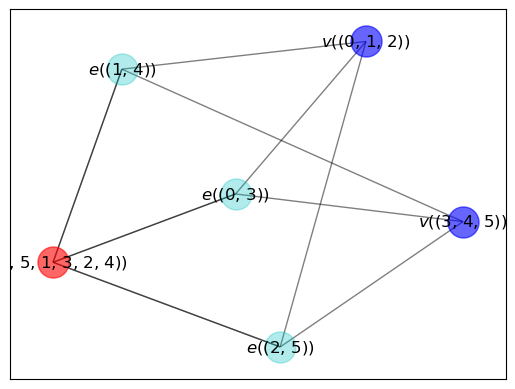

In [20]:
SCC.draw_graph('cycles', 'spring')

## Generalized Pauli Group for Qudits

While this is very useful, we would like a more general setup. In particular, we would like to have a surface code where each node represents a qudit of arbitrary dimension. We can think of this as a collection of systems, each of which is a $d_k$-level system, where the integer $d_k \geq 2$. These could be physically implemented as molecules for example. The *white nodes* given by the $2$-cycles in $\alpha$ will be $2$-level systems, i.e. *qubits*. These could be thought of as shared electrons that form molecular bonds since electrons are a typical example of a qubit. Each node represented by a cycle of $\sigma$ would then be a qudit where the dimension is determined by the length of the cycle. Similarly, for the dual dessin, the cycles of $\phi$ would also represent qudits with dimension determined by the length of the cycle. 

With this in mind we would like to define more general gates which generalize the Pauli and Clifford gates. In [Quantum Gates on Hybrid Qudits](http://zimp.zju.edu.cn/~xgwang/2003_A31012_Daboul_Wang_Barry.pdf) we see that the *Generalized Pauli Group* generated by the gates

\begin{align}
X^jZ^k, \quad & j, k \in \mathbb{Z}/d\mathbb{Z}
\end{align}

where 

\begin{align}
X^j|s\rangle &= |s+j \ (\text{mod} \ d)\rangle
\end{align}

and 

\begin{align}
Z|s\rangle &= \exp(2 \pi i s/d)|s\rangle \\
&= \zeta^s_d |s\rangle
\end{align}

where $\zeta_d = \exp(2 \pi i/d)$, form a basis for the operators on $\mathbb{H}_d = \mathbb{C}^d$. We call the group $\mathcal{P}_d = \langle X_j, Z_k \rangle$ the **Generalized Pauli Group**. The operators satisfy the following commutation relation:

\begin{align}
Z^jX^k &= \zeta_d^{jk}X^kZ^j,
\end{align}

and

\begin{align}
Z^d = X^d = I.
\end{align}

Below, we implement these as classes using Google Cirq. A specific case of the `QuditPlusGate` can be found for qutrits in the [documentation for Cirq](https://quantumai.google/cirq/build/qudits), which we call the `QuditXGate` here. We also implement the `QuditZGate` for qudits, the `QuditShiftGate`, and the `QuditFourierGate` which is the generalization of the Hadamard gate. The `QuditShiftGate` becomes important for implementing surface algebras. A periodic version of the shift operator can be represented as a matrix in the form

\begin{align}
\begin{pmatrix}
0 & 0 & 0 & \cdots & 0 & 0 & \zeta_d \\
1 & 0 & 0 & \cdots & 0 & 0 & 0 \\
0 & 1 & 0 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & 0 & 0 & 0 \\
0 & 0 & 0 & \cdots & 1 & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & 0 
\end{pmatrix}.
\end{align}


This operator, along with the standard shift and clock operator, appear on p. 7 of [Non-commutative geometry and matrix models](https://arxiv.org/abs/1109.5521) as generators for a **noncommutative or fuzzy torus**. In particular, we can view each qudit as providing us with a noncommutative torus, and we may consider *bundles of noncommutative tori* and *section* of those bundles. It is a common construction in noncommutative geometry to realize $C^*$-algebra of sections of a locally trivial continuous $C^*$-algebra bundle. We can then construct a pullback a multiple such bundles which is the construction developed in representation theory by mathematicians. 

In particular, this shift operator appears in the context of representation theory and algebraic geometry as well in Peter Magyar's paper [Affine Schubert Varieties and Circular Complexes](https://arxiv.org/pdf/math/0210151.pdf). They also appear in [Surface Algebras I](https://arxiv.org/pdf/1810.06750.pdf) and [Surface Algebras II](https://arxiv.org/pdf/1812.00621.pdf), where they are shown to be related to [Loop Algebras](https://en.wikipedia.org/wiki/Loop_algebra), [Loop Groups](https://en.wikipedia.org/wiki/Loop_group#:~:text=In%20its%20most%20general%20form,S1%20%E2%86%92%20G%2C%20i.e.), and [Affine Lie Algebras](https://en.wikipedia.org/wiki/Affine_Lie_algebra). This is important for the construction of local conformal field theories on a (possibly once punctured) disk. 

In [21]:
import cirq
import numpy as np

class QuditXGate(cirq.Gate):
    def __init__(self, node):
        self.node = node
        self.shift_plus()
        
    def shift_plus(self):
        self.plus_gate = np.eye(N=1, M=len(self.node), k=len(self.node)-1, dtype=np.uint8)
        shift_columns = np.eye(len(self.node), k=-1)
        self.x_gate = np.concatenate((self.plus_gate, shift_columns[1:,:]),axis=0)
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.shift_plus

    def _circuit_diagram_info_(self, args):
        return '[X]'


In [22]:
node = (1,2,3,4,5)
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditXGate(node).on(q0)
)
print(circuit)

0 (d=5): ───[X]───


In [23]:
QuditXGate(node).x_gate

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [24]:
import cirq
import numpy as np

class QuditZGate(cirq.Gate):
    def __init__(self, node, s):
        self.node = node
        self.s = s
        self.phase_gate()
        
        
    def phase_gate(self):
        t = np.exp(2*(self.s)*(np.pi)*1j/len(self.node))
        
        self.z_gate = np.eye(N=1, M=len(self.node))
        for j in range(1,len(self.node)):
            rows = np.eye(N=1, M=len(self.node), k=j)*(t**j)
            self.z_gate = np.vstack((self.z_gate, rows))
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.z_gate

    def _circuit_diagram_info_(self, args):
        return '[Z]'

In [25]:
node = (1,2,3)
QuditZGate(node,1).z_gate

array([[ 1. +0.j       ,  0. +0.j       ,  0. +0.j       ],
       [-0. +0.j       , -0.5+0.8660254j, -0. +0.j       ],
       [ 0. -0.j       ,  0. -0.j       , -0.5-0.8660254j]])

In [26]:
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditZGate(node,1).on(q0)
)
print(circuit)

0 (d=3): ───[Z]───


In [27]:
import cirq
import numpy as np

class QuditShiftGate(cirq.Gate):
    def __init__(self, node):
        self.node = node
        self.shift_phase_plus()
        
    def shift_phase_plus(self):
        t = np.exp(2*(np.pi)*1j/len(self.node))
        self.plus_gate = np.eye(N=1, M=len(self.node), k=len(self.node)-1, dtype=np.uint8)*t
        shift_columns = np.eye(len(self.node), k=-1)
        self.shift_gate = np.concatenate((self.plus_gate, shift_columns[1:,:]),axis=0)
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.shift_plus

    def _circuit_diagram_info_(self, args):
        return '[Shift]'


In [28]:
node = (1,2,3)
QuditShiftGate(node).shift_gate

array([[-0. +0.j       , -0. +0.j       , -0.5+0.8660254j],
       [ 1. +0.j       ,  0. +0.j       ,  0. +0.j       ],
       [ 0. +0.j       ,  1. +0.j       ,  0. +0.j       ]])

In [29]:
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditShiftGate(node).on(q0)
)
print(circuit)

0 (d=3): ───[Shift]───


## Fourier Gates

Fourier gates involve the [Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform). We have a [tutorial notebook on the QFT](https://github.com/The-Singularity-Research/quantum-fourier-transform). 

\begin{align}
|s) &= F|s\rangle \\
&= \frac{1}{\sqrt{d}}\sum_{k=0}^{d-1}\zeta^{sk}|k\rangle, \quad s \in \mathbb{Z}/d\mathbb{Z}
\end{align}

where 

\begin{align}
\langle s'|s) &= \frac{1}{\sqrt{d}}\zeta^{ss'}.
\end{align}

The dual states $|s)$ are related to the computational basis by a *discrete Fourier transformation*. The $F$ gate is a qudit version of the one-qubit Hadamard gate $H$. However, the $F$ operator for $d \geq 3$ is *not* Hermitian and its order is $4$ instead of $2$, unlike the usual qubit Hadamard gate

\begin{align}
H = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}.
\end{align}

Let's look at an example of how to construct the $F$-gate. 

In [30]:
node = (1,2,3)

t = np.exp(2*(np.pi)*1j/len(node))
print(t)

(-0.4999999999999998+0.8660254037844388j)


In [31]:
t_list = list()
for j in range(len(node)):
    t_list.append(t**j)
print(t_list)

[(1+0j), (-0.4999999999999998+0.8660254037844388j), (-0.5000000000000006-0.8660254037844385j)]


In [32]:
t_list = np.array(t_list)
t_list = np.reshape(t_list,(1,len(node)))
t_list = np.round_(t_list, decimals=5, out=None)
print(t_list)

[[ 1. +0.j      -0.5+0.86603j -0.5-0.86603j]]


In [33]:
row_list = t_list**0
for j in range(1,len(node)):
    row_list = np.vstack((row_list, t_list**j))
print(row_list)

[[ 1.        +0.j       1.        +0.j       1.        +0.j     ]
 [ 1.        +0.j      -0.5       +0.86603j -0.5       -0.86603j]
 [ 1.        +0.j      -0.50000796-0.86603j -0.50000796+0.86603j]]


We can turn this into a class so that we have a single qudit gate in Cirq as follows. 

In [34]:
import cirq
import numpy as np

class QuditFourierGate(cirq.Gate):
    def __init__(self, node):
        self.node = node
        self.t = np.exp(2*(np.pi)*1j/len(self.node))
        self.f_gate()
        
        
    def f_gate(self):
        t_list = list()
        for j in range(len(node)):
            t_list.append(t**j)
        t_list = np.array(t_list)
        t_list = np.reshape(t_list,(1,len(node)))
        t_list = np.round_(t_list, decimals=5, out=None)
        
        row_list = t_list**0
        for j in range(1,len(node)):
            row_list = np.vstack((row_list, t_list**j))
        self.fourier_gate = row_list**(1/len(self.node))
        
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.fourier_gate

    def _circuit_diagram_info_(self, args):
        return '[F]'

In [35]:
node = (1,2,3,4)

In [36]:
F = QuditFourierGate(node)

In [37]:
F.fourier_gate

array([[1.        +0.00000000e+00j, 1.        +0.00000000e+00j,
        1.        +0.00000000e+00j, 1.        +0.00000000e+00j],
       [1.        +0.00000000e+00j, 0.86602655+5.00000000e-01j,
        0.86602655-5.00000000e-01j, 1.        +0.00000000e+00j],
       [1.        +0.00000000e+00j, 0.86602655-5.00001990e-01j,
        0.86602655+5.00001990e-01j, 1.        +0.00000000e+00j],
       [1.        +0.00000000e+00j, 1.00000299-1.72357912e-06j,
        1.00000299+1.72357912e-06j, 1.        +0.00000000e+00j]])

In [38]:
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditFourierGate(node).on(q0)
)
print(circuit)

0 (d=4): ───[F]───


## Hybrid Qudit Surface Codes

In [39]:
from collections import Counter
from typing import Tuple, List

from networkx import MultiGraph
import networkx as nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation

import matplotlib.pyplot as plt


# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary = self.code_graph.neighbors(face)
        return boundary

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def draw(self, node_type='', layout = ''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        
        if layout == 'spring':
            pos=nx.spring_layout(self.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show() # display

Now, we create a class that creates a surface code circuit with qudits based on the lengths of the cycles in the dessin $[\sigma, \alpha, \phi]$. Our next goal will be to implement hybrid two-qudit gates. 

In [40]:
import cirq
import numpy as np
from typing import Tuple
import networkx as nx

# from qiskit import
# from src import SurfaceCodeGraph


class MixedSurfaceCodeCircuit():

    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        # super().__init__()
        self.sigma = sigma
        self.alpha = alpha

        self.scgraph = SurfaceCodeGraph(self.sigma, self.alpha)

        '''
        Compute the permutation corresponding to phi and create a 
        'surface code circuit' based on a (multi)graph 'surface_code_graph'
        given by sigma, alpha, and phi
        Create quantum and classical registers based on the number of nodes in G
        '''
        # f = self.scgraph.compute_phi()
        self.phi = self.scgraph.phi

        self.qubits = [cirq.NamedQubit(str(node)).with_dimension(len(node)) for node in self.scgraph.code_graph.nodes]
        self.circuit = cirq.Circuit()

        self.node_info = self.scgraph.node_dict
        self.sigma_dict, self.alpha_dict, self.phi_dict = self.node_info

            
    

    def draw_circuit(self, render=''):
        # if render == 'mpl':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw('mpl')

        # if render == 'plain':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw()

        if render == '':
            print(self.circuit)


    def draw_graph(self, node_type='', layout=''):
        if layout == 'spring':
            pos = nx.spring_layout(self.scgraph.code_graph)
        if layout == 'spectral':
            pos = nx.spectral_layout(self.scgraph.code_graph)
        if layout == 'planar':
            pos = nx.planar_layout(self.scgraph.code_graph)
        if layout == 'shell':
            pos = nx.shell_layout(self.scgraph.code_graph)
        if layout == 'circular':
            pos = nx.circular_layout(self.scgraph.code_graph)
        if layout == 'spiral':
            pos = nx.spiral_layout(self.scgraph.code_graph)
        if layout == 'random':
            pos = nx.random_layout(self.scgraph.code_graph)
        if node_type == 'cycles':
            self.scgraph.draw('cycles', layout)
        if node_type == 'dict':
            self.scgraph.draw('dict', layout)

## Noncommutative Tori

The **shift** and **clock** operators, 

$$
\begin{align}
U = \begin{pmatrix}
0 & 0 & 0 & \cdots & 0 & 0 & 1 \\
1 & 0 & 0 & \cdots & 0 & 0 & 0 \\
0 & 1 & 0 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & 0 & 0 & 0 \\
0 & 0 & 0 & \cdots & 1 & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & 0 
\end{pmatrix}, \quad
V = \begin{pmatrix}
\omega & 0 & 0 & \cdots & 0 & 0 & 0 \\
0 & \omega^2 & 0 & \cdots & 0 & 0 & 0 \\
0 & 0 & \omega^3 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & \omega^{n-2} & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & \omega^{n-1} & 0 \\
0 & 0 & 0 & \cdots & 0 & 0 & 1 
\end{pmatrix}
\end{align}\\
$$

generate the matrix algebra $M_n(\mathbb{C}) = \mathfrak{gl}_n(\mathbb{C}).$ They also satisfy the relations,

$$
UV = e^{\theta}VU.
$$

A pullback, with corresponding tensor product construction, of algebras of the form 

$$ C^{\infty}(S^1) \otimes_{\mathbb{C}} M_n(\mathbb{C}),$$ 

for various $n$ corresponding to the half edges of a vertex of a dessin d'enfant, gives a surface algebras and quantum surface codes duality corresponding to the duality between a noncommutative space and its (noncommutative) algebra of functions. This is related to the algebra $M_{\infty}(\mathbb{C})$, and in fact, [Harish-Chandra modules](https://iopscience.iop.org/article/10.1070/RM1968v023n02ABEH001237/meta) of the former can be seen as coverings of the quiver of the former coming from group actions on the quiver of the latter (see $\S 1.6$ pg. 245 [Gabriel-Riedmann](https://eudml.org/doc/139782), [Herschend1](https://eudml.org/doc/286491), and [Herschend2](https://www.sciencedirect.com/science/article/pii/S0022404910000368)). Here we are viewing 

$$ C^{\infty}(S^1) \otimes_{\mathbb{C}} M_n(\mathbb{C}) = M_n(C^{\infty}(\mathbb{T})),$$

as the [graph $C^*$-algebra](https://en.wikipedia.org/wiki/Graph_C*-algebra#Examples) coming from the cyclic oriented quiver $\tilde{\mathbb{A}}_{n}$ with $n$ arrows, and $M_{\infty}(\mathbb{C})$ is the graph $C^*$-algebra of the infinite linearly order quiver sometimes called $\mathbb{A}_{\infty}$, but we can also use $_{\infty}\mathbb{A}_{\infty}$ as a covering quiver to generate modules Harish-Chandra. This gives $\mathbb{Z}^2$ matrices instead of $\mathbb{N}^2$ matrices. It may also be helpful to think of $M_{\infty}(\mathbb{C})$ as the AF-algebra limit:

$$
M_n(\mathbb{C}) \to M_{2n}(\mathbb{C}) \to M_{3n}(\mathbb{C}) \to  \cdots.
$$

Here, we view the action by rational rotations as a group action on the circle manifold $S^1$, and the discrete submanifold given by $n^{th}$-roots of unity. This gives us a $C^*$-algebra construction as described in $\S 7$ [The Orbit Space of a Group Action](https://alainconnes.org/wp-content/uploads/book94bigpdf.pdf) of Connes.

## References

#### Primary
[Fault-Tolerant Quantum Computation with
Higher-Dimensional Systems](https://arxiv.org/pdf/quant-ph/9802007.pdf)

[Qudit surface codes and gauge theory with finite
cyclic groups](https://arxiv.org/pdf/quant-ph/0609070.pdf)

#### Secondary

[Non-commutative geometry and matrix models](https://arxiv.org/abs/1109.5521)

[Ground state degeneracy on torus in a family of ZN toric code](https://arxiv.org/abs/2211.00299)


## Software Documentation

[Google Cirq Qudits](https://quantumai.google/cirq/build/qudits)

## $C^*$-Algebras and Noncommutative Geometry

[Math Overflow: A question on quantum tori](https://mathoverflow.net/questions/358052/a-question-on-quantum-tori)

[On Factor Representations and the $C^*$-Algebra
of Canonical Commutation Relations](https://projecteuclid.org/journals/communications-in-mathematical-physics/volume-24/issue-2/On-factor-representations-and-the-C-algebra-of-canonical-commutation/cmp/1103857742.full)

[Classification of C*-algebras admitting ergodic actions of the two-dimensional torus](https://eudml.org/doc/152389)

[$C^*$-Algebras Associated with Irrational Rotations](https://msp.org/pjm/1981/93-2/pjm-v93-n2-p12-s.pdf)

[From Large N Matrices to the
Noncommutative Torus](https://arxiv.org/pdf/hep-th/9912130.pdf)

[Toeplitz Density Operators and their Separability Properties](https://arxiv.org/abs/2209.08051)


## Closing Thoughts and Future Directions

- Make sure $\mathbb{Z}/2\mathbb{Z}$ coefficients are all changed to $\mathbb{Z}/d\mathbb{Z}$ and/or $\mathbb{Z}$ coefficients in a new `SurfaceCodeGraph` class for the more general hybrid qudit surface codes, where $d$ is the valency of a vertex. 
- Change boundary and coboundary operators and matrix differentials to match the new coefficients
- Ellaborate on the `X`, `Z`, and `Shift` operators for qudits, and show how `Shift` operators are important in surface algebras
- Implement [Toeplitz operators (SciPy)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.toeplitz.html), (see [this reference](https://ee.stanford.edu/~gray/toeplitz.pdf) for background theory on Toeplitz and circulant matrices and their applications)
- Implement [circular convolution](https://49paulnilay.medium.com/circular-convolution-using-python-b2118236a693) (see [also](https://www.geeksforgeeks.org/circular-convolution-using-matrix-method/)) and *correlation* as [custom unitaries](https://quantumai.google/cirq/build/custom_gates) or using the quantum Fourier transform. 
- Implement multi-qubit gates for entangling. [Arbitrary controlled unitaries](https://quantumai.google/cirq/build/custom_gates) (or `CU` gates) would be useful for generalizing surface codes further. Perhaps a distance measure from some well known entangling gate like a generalized `CNOT` would give a measure of how entangled two qudits are. How similar are the interaction graphs?
- Use unitary operators on qudits and quantum Fourier transform to construct Tony Plate's [Holographic Reduced Representations](http://www2.fiit.stuba.sk/~kvasnicka/CognitiveScience/6.prednaska/plate.ieee95.pdf) and their circular convolution operators. Using surface codes, this may mix HRRs and [Tensor Product Representations](http://www.lscp.net/persons/dupoux/teaching/AT1_2014/papers/Smolensky_1990_TensorProductVariableBinding.AI.pdf) into a single model of quantum memory. This would be a fundamental holographic associative memory, and a tensor product memory, present in matter.
- If [Recasting Self-Attention with Holographic Reduced
Representations](https://mdsoar.org/bitstream/handle/11603/26128/MILETS_2022_paper_5942.pdf?sequence=1&isAllowed=y) is correct, this could prove that the *attention mechanism*, encoded in *circular convolutions* and *correlations* of HRRs, are fundamental to the universe. In particular, the universe, using attention, approximates equivariance with respect to local symmetry groups (locality being defined via entanglement as a notion of distance between qudits, and clusters of qudits that are *'near'* each other being given by highly entangled groups of qudits). Some types of topologically ordered matter will have very structured symmetry groups that will be related to the topology of the cluster of highly entangled particles. So, for example, of a local cluster of highly entangled particles has persistent homology showing it has the structure of say a two holed torus, then there will be an emergent generalized hybrid qudit surface code, made of qudits entangled using `CU` gates. The entanglement of the `CU` gates, again, is the notion of distance and will be the parameter used in defining persistent homology. 
- Use decoding to determine how similar two vector concepts are, use this as a parameter for clustering, get a knowledge graph with clusters or maybe some kind of persistent homology of concepts?
- Encoding and decoding using circular convolution and correlation could be used as a form of quantum neural cryptography if the following resource is correct [CSPS HRR Network Pseudo-encryption](https://github.com/NeuromorphicComputationResearchProgram/Connectionist-Symbolic-Pseudo-Secrets).
- Can we take hybrid qudits surface codes, implement local HRRs on each qudit (maybe use quantum Fourier gates and circulant/Toeplitz matrices implemented as custom gates), then construct a Tensor Product Representation type network for the global surface code? Using the "CSPS HRR Network Pseudo-encryption" method on the HRR parts gives local encoding/decoding of sybolic relational structures on state vectors/density operators. Do we need something like a TPR to construct the global theory of decoding optical quantum information (i.e. observational data from 'measuring' a subsystem)? How would we "stack" this "on top of" a bunch of local HRRs on the qudits? What global or multiqubit gates are important for encoding and decoding symbolic relationships that are potentially nonlocal? What semantic/knowledge graph type info do we retrieve from this? If we train some kind of deep learning model as if this were the "language of the universe" what might we find out about the language and how it relates to known languages?
- If attention is actually encoded in HRRs properly, and this approximates group equivariance with respect to (compact continuous) groups, can we improve our model by encoding this equivariance directly rather than learning an approximation to it? Furthermore, what biases will we introduce in this procedure? What equivariances will we find culturally and spiritually significant? Again, do we stack an TPR on top of local HRRs? Do we alternate between HRRs and TPRs, with TPRs gradually combining multiple surface codes?